In [ ]:
# LUNEDI: ricontrollare metodo opzioni per taxon con depth maggiore di 7 (taxons di sinonimi, sottospecie, etc.)

# TODO: define method to discriminate if an image is allowed to have questions: to_remove, depth<6...(?)
# - symptom, damage no species questions
# - difficulty, other criteria: frequency
# - use captions

# Note



- In plants, ignore tags: tag-symptoms, eradicate tags: tag-eradication, if tag-invaded-area ask which WEED is this?
- In protista, ignore all tags baby
- In Bacteria, eradicate tag-adult because just two, tag-damage: difficult questions, maybe we can retrieve the attacked species, tag-diagnostic eradictated!!, tag-egg: eRATICATE

In [3]:
import pandas as pd
from tqdm import tqdm
import requests
import urllib
import random
from multiprocessing import Pool
import matplotlib.pyplot as plt
from collections import Counter
import asyncio
import aiohttp
import urllib.parse
from anytree import Node, RenderTree
from random import choice, sample, shuffle

from collections import defaultdict

from PIL import Image, ImageDraw
import requests
from io import BytesIO
import math
from concurrent.futures import ProcessPoolExecutor
from itertools import cycle

In [4]:
kingdoms = [
 'Archaea',
 'Bacteria',
 'Chromista',
 'Viruses_and_viroids',
 'Fungi',
 'Protista',
 'Plantae',
 'Animalia']

dfs = {'EPPO':{}, 'GBIF':{}}

root_dir_eppo = '/workdir/important_datasets/EPPO Dataframes/Kingdom/'
root_dir_gbif = '/workdir/important_datasets/EPPO_to_GBIF/'

for kingdom in kingdoms:
    df_file_path = root_dir_gbif+f'df.{kingdom}_EPPO_to_GBIF.gzip'
    df = pd.read_parquet(df_file_path, engine='pyarrow')
    numeric_cols = df.select_dtypes(include=['number']).columns
    dfs['GBIF'][kingdom] = df.astype({col: 'Int64' for col in numeric_cols})
    
    df_file_path = root_dir_eppo+f'df.{kingdom}.EPPO.gzip'
    df = pd.read_parquet(df_file_path, engine='pyarrow')
    numeric_cols = df.select_dtypes(include=['number']).columns
    dfs['EPPO'][kingdom] = df.astype({col: 'Int64' for col in numeric_cols})

In [5]:
def plot_tag_histogram(count_tags, title):
    """
    Plots a histogram from a dictionary of tag counts.
    
    Parameters:
    - tag_counts (dict): A dictionary where keys are tags and values are their respective counts.
    """
    tags = list(count_tags.keys())
    counts = list(count_tags.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(tags, counts, color='skyblue', edgecolor='black')
    plt.xlabel('Tags', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def count_tags(EPPO_images):
    count_tags = {kingdom: defaultdict(int) for kingdom in kingdoms}

    for kingdom in kingdoms:
        for image in EPPO_images[kingdom]:
            for tag in image.tag:
                count_tags[kingdom][tag] += 1

    count_tags = {kingdom: dict(value) for kingdom, value in count_tags.items()}
    return count_tags

In [6]:
def get_kingdom_word(kingdom):
    if kingdom == 'Plantae':
        return 'plant'
    elif kingdom == 'Animalia':
        return 'animal'
    elif kingdom == 'Fungi':
        return 'fungus'
    elif kingdom == 'Bacteria':
        return 'bacterium'
    elif kingdom == 'Archaea':
        return 'archaeon'
    elif kingdom == 'Protista':
        return 'protist'
    elif kingdom == 'Chromista':
        return 'chromist'
    elif kingdom == 'Viruses_and_viroids':
        return 'virus'
    else:
        return

In [7]:
def get_taxonomic_path_row(row):
    
    if pd.isna(row['key']):
        return {}
    
    columns = ['EPPO_code', 'key']
    new_row = {column: row[column] for column in columns}
    name = (row.get('canonicalName') if row.get('canonicalName') else row.get('scientificName'))
    key = row['key']
    classification_map = (row['higherClassificationMap'])
    if classification_map:
        classification_map_dict = eval(row['higherClassificationMap'])
        classification_map = list(classification_map_dict.items())
        classification_map += [(str(key), name)]
        new_row['taxonomic_path'] = classification_map
    return new_row


def get_taxonomic_path(df):
    data = [get_taxonomic_path_row(row) for _, row in df.iterrows()]
    return pd.DataFrame(data)

trees={}
for kingdom in kingdoms:
    df_paths = get_taxonomic_path(dfs['GBIF'][kingdom])
    paths = [row['taxonomic_path'] for _, row in df_paths.iterrows() if isinstance(row['taxonomic_path'], list)]
    root = Node("root")
    nodes = {}

    for path in paths:
        parent = root
        for node in path:
            if node not in nodes:
                nodes[node] = Node(node, parent=parent)
            parent = nodes[node]
    trees[kingdom]=nodes
            

In [8]:
def update_kwargs(kwargs):
    if 'kingdom' in kwargs:
        kwargs.update({'kingdom_word': get_kingdom_word(kwargs['kingdom'])})
    return kwargs

In [9]:
def search_growth_stage_tag(tags):
    good_tags = ['egg', 'eggs', 'larva', 'pupa', 'adult'] 
    for tag in tags:
        tag=tag[4:]
        if tag in good_tags:
            return tag

In [53]:
class EPPOImage():
    def __init__(self, image, taxon):
        self.image_path = image['url']
        self.tag = image['tag']
        self.caption = image['cap']
        self.taxon = taxon
    
    def __str__(self):
        # Start by defining the order of attributes
        ordered_attrs = [
            ('Image_path', self.image_path if hasattr(self, 'image_path') else None),
            ('Tag', self.tag),
            ('Caption', self.caption),
        ]

        # Add any other attributes dynamically (if any)
        for attr in dir(self):
            if not callable(getattr(self, attr)) and not attr.startswith("__") and attr not in ['image_path', 'tag', 'caption', 'correct_answer']:
                ordered_attrs.append((attr.capitalize(), getattr(self, attr)))

        # Format and return the string in the correct order
        formatted_attrs = '\n'.join(f"{key}: {value}" for key, value in ordered_attrs if value is not None)
        response = requests.get(self.image_path)
        image = Image.open(BytesIO(response.content))
        plt.imshow(image)
        plt.axis('off')  # Turn off axis labels
        plt.show()
        return formatted_attrs
    
    def get_question(self, question_template, difficulty, num_options=3, with_balance_info=False, **question_kwargs):
        image_path = self.image_path
        taxon = self.taxon
        
        if question_template.tag == 'growth_stage':
            correct_answer = self.valid_growth_stage()
            if not correct_answer:
                print('No valid growth stage!')
                return
            options = ['egg', 'larva', 'pupa', 'adult'] 
        else:
            correct_answer = taxon.get_attr('canonicalName')
            options = taxon.get_random_neighbors(6-difficulty, num=num_options, with_balance_info=with_balance_info)
            if len(options) < num_options:
                #print(f'({taxon.gbif_key}, {correct_answer})\t {len(options)} {options}')
                return
            #options = [node.name[1] for node in sample(options, num_options)]
            options.append(correct_answer)
        shuffle(options)
        
        question_template.update(options=options, correct_answer=correct_answer, difficulty=difficulty, image_path=image_path, kingdom=taxon.kingdom, **question_kwargs)
        
        return question_template
    
    def valid_growth_stage(self):
        growth_stages = ['tag-adult', 'tag-larva', 'tag-pupa', 'tag-egg', 'tag-eggs']
        possible_tag = []
        for tag in self.tag:
            if tag in growth_stages:
                possible_tag.append(tag)
        if len(possible_tag) == 1:
            valid_tag = possible_tag[0][4:] #cut 'tag-' prefix
            if valid_tag.startswith('egg'):
                valid_tag = 'egg'
            return valid_tag
        
    
    
class Taxon():
    def __init__(self, gbif_key, row_eppo, row_gbif, kingdom, index, trees=trees, dfs=dfs):
        self.gbif_key = gbif_key
        self.taxontree = trees[kingdom]
        self.kingdom = kingdom
        self.index = index
        self.df_eppo = dfs['EPPO'][kingdom]
        self.df_gbif = dfs['GBIF'][kingdom]
        self.row_eppo = row_eppo
        self.row_gbif = row_gbif
        
    def get_attr(self, attr, fallback=None):
        if pd.isna(self.row_eppo.get(attr)) and pd.isna(self.row_gbif.get(attr)):
            return fallback
        elif self.row_eppo.get(attr):
            return self.row_eppo.get(attr)
        elif self.row_gbif.get(attr):
            return self.row_gbif.get(attr)
        else:
            if fallback is None:
                print('Svegliaaaa attributo inesistente')
            return fallback
    
    def get_node(self):
        key = str(self.get_attr('key'))
        #name = str(self.get_attr('canonicalName'))
        name = str(self.get_attr('canonicalName') if self.get_attr('canonicalName') else self.get_attr('scientificName'))
        return self.taxontree.get((key, name))
       
    def get_neighbors(self, distance):
        return get_neighbors_node(self.get_node(),distance)
    
    def get_random_neighbors(self, distance, num=3, with_balance_info=False):
        if not self.get_node():
            print(self)
        nodes = get_random_neighbors_node(self.get_node(), distance, num, with_balance_info)
        options = [node.name[1] for node in nodes]
        return  options
             


    def __str__(self):
        return self.get_attr('canonicalName', '')
    
        
def find_node(key, taxons):
    for tax in taxons:
        if not pd.isna(tax.gbif_key):
            if tax.gbif_key==key:
                return tax
    print('Not Found')

def get_neighbors_node(node, distance):
    if distance==0:
        return [node]
    neighbors=[]
    ancestor=node.ancestors[-distance]
    sub_ancestors = [ [child for child in ancestor.children if child != node.ancestors[-distance + 1]] ]
    for sub_ancestor in sub_ancestors:
        for descendant in sub_ancestor.descendants:
            if descendant.depth==node.depth:
                #if distance == 1: # 
                    #if descendant != node:
                        neighbors.append(descendant)
    return neighbors

def get_random_neighbors_node(node, distance, num=3, with_balance_info=False):
    if node.depth<=4:
        return []
    
    if node.depth>7:
        distance=distance+1
        max_depth=node.depth+1
        min_depth=7
    else:
        max_depth=node.depth+1
        min_depth=node.depth
    ancestor = node.ancestors[-distance]
    if distance == 0:
        return []
    if distance == 1:
        if len(ancestor.children) - 1 < num:
            return []
        return sample([child for child in ancestor.children if child != node], num)
    
    intermediate_ancestor = node.ancestors[-distance + 1]
    sub_ancestors = [child for child in ancestor.children if child != intermediate_ancestor]
    shuffle(sub_ancestors)
    
    neighbors = []
    sub_ancestor_cycle = cycle(sub_ancestors)  # Cycle through sub_ancestors
    found=0
    
    for sub_ancestor in sub_ancestor_cycle:
        if len(neighbors) >= num or found>len(sub_ancestors):
            break
        descendants = list(descendant for descendant in sub_ancestor.descendants)
        shuffle(descendants)
        for descendant in descendants:
            if min_depth <= descendant.depth <max_depth and descendant not in neighbors:
                neighbors.append(descendant)
                found=0
                break
        found +=1 
        
    
    # if equidistant neighbors is not ensured balanced is False
    if with_balance_info:
        return {'result': neighbors, 'balanced': (len(sub_ancestors) >= num)}
    
    return neighbors       

In [11]:
question_templates = {
    'scientific_name':  'What is the scientific name of this {kingdom_word}?',
                        
    'common_name':      'What is the common name in {language} of this {kingdom_word}?',
                        
    'genus_name':       'Which genus does this {kingdom_word} belong to?',
                        
    'major_pest':       'Which of the following is a major pest of this plant?',
        
    'weed':             'What is the scientific name of the invasive weed in this image?',
    
    'damage_cause':     'What is the scientific name of the {kingdom_word} causing this damage?', #tag-symptom, tag-damage
    
    'growth_stage':     'At what growth stage is this {kingdom_word}?',
}



class Question:
    def __init__(self, question='', options=[], correct_answer='', difficulty=0):
        self.correct_answer = correct_answer
        self.options = options
        self.difficulty = difficulty
        self.question = question

    def print_question(self):
        return {
            'question': self.question,
            'options': self.options,
            'correct_answer': self.correct_answer,
            'difficulty': self.difficulty
        }
    
    def __str__(self):
        # Start by defining the order of attributes
        ordered_attrs = [
            ('Kingdom', self.kingdom if hasattr(self, 'kingdom') else None),
            ('Image_path', self.image_path if hasattr(self, 'image_path') else None),
            ('Question', self.question),
            ('Options', self.options),
            ('Correct_answer', self.correct_answer),
        ]

        # Add any other attributes dynamically (if any)
        for attr in dir(self):
            if not callable(getattr(self, attr)) and not attr.startswith("__") and attr not in ['kingdom', 'image_path', 'question', 'options', 'correct_answer']:
                ordered_attrs.append((attr.capitalize(), getattr(self, attr)))

        # Format and return the string in the correct order
        formatted_attrs = '\n'.join(f"{key}: {value}" for key, value in ordered_attrs if value is not None)
        return formatted_attrs


    
class IdentificationQuestion(Question):
    def __init__(self, tag='', question_template='', options=[], correct_answer='', difficulty=0, image_path='', **kwargs):
        
        self.question_template = question_template
        self.tag = tag
        
        if not self.question_template and self.tag:
            self.question_template = question_templates[self.tag]
            
        self.image_path = image_path
        self.kwargs = kwargs

        
        for key, value in kwargs.items():
            setattr(self, key, value)
        super().__init__(question_template,  options, correct_answer, difficulty)
        
    def update(self, **extra_kwargs):

        self.kwargs.update(extra_kwargs)
        self.kwargs = update_kwargs(self.kwargs)
        self.question = self.question_template.format(**self.kwargs)
        
        for key, value in self.kwargs.items():
            setattr(self, key, value)
        return self       


In [54]:
taxons = {}
EPPO_images = {}
tags = {}

for kingdom in kingdoms:
    taxons[kingdom] = []
    EPPO_images[kingdom] = []
    tags[kingdom] = set()
    
    for (i,e) , (j,g) in tqdm(zip(dfs['EPPO'][kingdom].iterrows(),dfs['GBIF'][kingdom].iterrows())):
        if pd.isna(g['key']):
            continue 
        taxon = Taxon(g['key'],e,g,kingdom,j)
        images = eval(taxon.get_attr('Images', '[]'))
        
        if images:
            for image in images:
                eppo_image = EPPOImage(image, taxon)
                EPPO_images[kingdom].append(eppo_image)
                
                tags[kingdom] = tags[kingdom].union(set(x[4:] for x in image['tag']))
        taxons[kingdom].append(taxon)

13it [00:00, 4850.20it/s]
0it [00:00, ?it/s]

1029it [00:00, 6855.56it/s]
592it [00:00, 7699.03it/s]
1909it [00:00, 8127.76it/s]
8327it [00:01, 7974.70it/s]
89it [00:00, 7478.57it/s]
58298it [00:10, 5694.04it/s]
27501it [00:03, 8221.38it/s]


In [55]:
for kingdom in kingdoms:
    c=0
    for taxon in taxons[kingdom]:
        if not taxon.get_attr('key'):
            c += 1
    print(kingdom,': ',c)

Archaea :  0
Bacteria :  0
Chromista :  0
Viruses_and_viroids :  0
Fungi :  0
Protista :  0
Plantae :  0
Animalia :  0


In [56]:
errors={}
c = 0
for kingdom in kingdoms:
    errors[kingdom]={}
    for difficulty in range(1,6):
        errors[kingdom][difficulty]=0
        for image in EPPO_images[kingdom]:
            if image.valid_growth_stage():
                q_temp = IdentificationQuestion('common_name')
                quest = image.get_question(q_temp, difficulty, language='english')
                if quest is None:
                    errors[kingdom][difficulty] += 1
                    #c += 1  
                    #print(c)#, image)
                #questions.append(quest)

In [57]:
errors

{'Archaea': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
 'Bacteria': {1: 0, 2: 1, 3: 2, 4: 1, 5: 1},
 'Chromista': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
 'Viruses_and_viroids': {1: 0, 2: 1, 3: 1, 4: 0, 5: 1},
 'Fungi': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
 'Protista': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
 'Plantae': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
 'Animalia': {1: 0, 2: 0, 3: 0, 4: 87, 5: 1165}}

In [25]:
# LUNEDI: ricontrollare opzioni per taxon con depth maggiore di 7 (taxons)
node = ('7024740', 'Meloidogyne graminicola')
print(trees['Animalia'][node].depth)
ancestor=trees['Animalia'][node].ancestors[-1]
children = ancestor.children
print(ancestor.name, ancestor.depth)
for child in children:
    print('->',child.name,child.depth)
    for des in child.descendants:
        print('->-->',des.name, des.depth)#.get_node(('7024262', 'Anguillulina aberrans'))

7
('9705419', 'Meloidogyne') 6
-> ('7024740', 'Meloidogyne graminicola') 7
-> ('7024698', 'Meloidogyne enterolobii') 7
-> ('4556295', 'Meloidogyne chitwoodi') 7
-> ('7024683', 'Meloidogyne ethiopica') 7
->--> ('10703378', 'Meloidogyne brasiliensis') 8
-> ('11535849', 'Meloidogyne luci') 7
-> ('7024726', 'Meloidogyne mali') 7
-> ('4556296', 'Meloidogyne fallax') 7
-> ('7024718', 'Meloidogyne floridensis') 7
-> ('2283983', 'Meloidogyne naasi') 7
-> ('2283981', 'Meloidogyne exigua') 7
-> ('7024707', 'Meloidogyne minor') 7
-> ('11577189', 'Meloidogyne vitis') 7
-> ('7024736', 'Meloidogyne coffeicola') 7
-> ('7024727', 'Meloidogyne kongi') 7
-> ('2283984', 'Meloidogyne acronea') 7
-> ('4556301', 'Meloidogyne duytsi') 7
-> ('7024704', 'Meloidogyne jianyangensis') 7
-> ('4556287', 'Meloidogyne javanica') 7
-> ('7024731', 'Meloidogyne izalcoensis') 7
-> ('4556282', 'Meloidogyne incognita') 7
->--> ('12310441', 'Meloidogyne incognita acrita') 8
->--> ('12073350', 'Meloidogyne polycephannulata')

In [513]:
trees['Animalia'][('1347638', 'Sphex rufocinctus')]

Node("/root/('1', 'Animalia')/('54', 'Arthropoda')/('216', 'Insecta')/('1457', 'Hymenoptera')/('4352', 'Sphecidae')/('1311747', 'Sphex')/('1347633', 'Sphex flavipennis')/('1347638', 'Sphex rufocinctus')")

In [509]:
node=find_node(4517187,taxons['Animalia'])
node.get_random_neighbors(distance=3,num=3)

['Stenodiplosis geniculati', 'Leucopis americana', 'Palloptera usta']

In [482]:
# Eliminate all taxon that has higherClassificationMap <= 4
depths = {kingdom : {num: 0 for num in range(10)} for kingdom in kingdoms} 

for kingdom in kingdoms:
    for image in EPPO_images[kingdom]:
        taxon=image.taxon
        depth = len(eval(taxon.get_attr('higherClassificationMap', '[]')))
        if depth > 6  and taxon.get_attr('canonicalName',None) and taxon.get_attr('rank')!='SPECIES':
            print(kingdom, eval(taxon.get_attr('higherClassificationMap', '[]')),taxon, taxon.get_attr('taxonomicStatus'),taxon.get_attr('rank'))
            #print(image)
        depths[kingdom][depth] += 1

Bacteria {'3': 'Bacteria', '111': 'Proteobacteria', '362': 'Gammaproteobacteria', '820': 'Xanthomonadales', '5611': 'Xanthomonadaceae', '3220012': 'Xanthomonas', '11435865': 'Xanthomonas cissicola'} Xanthomonas citri citri DOUBTFUL SUBSPECIES
Bacteria {'3': 'Bacteria', '111': 'Proteobacteria', '362': 'Gammaproteobacteria', '820': 'Xanthomonadales', '5611': 'Xanthomonadaceae', '3220012': 'Xanthomonas', '11435865': 'Xanthomonas cissicola'} Xanthomonas citri citri DOUBTFUL SUBSPECIES
Bacteria {'3': 'Bacteria', '111': 'Proteobacteria', '362': 'Gammaproteobacteria', '820': 'Xanthomonadales', '5611': 'Xanthomonadaceae', '3220012': 'Xanthomonas', '11435865': 'Xanthomonas cissicola'} Xanthomonas citri citri DOUBTFUL SUBSPECIES
Bacteria {'3': 'Bacteria', '111': 'Proteobacteria', '362': 'Gammaproteobacteria', '820': 'Xanthomonadales', '5611': 'Xanthomonadaceae', '3220012': 'Xanthomonas', '11435865': 'Xanthomonas cissicola'} Xanthomonas citri citri DOUBTFUL SUBSPECIES
Bacteria {'3': 'Bacteria', '

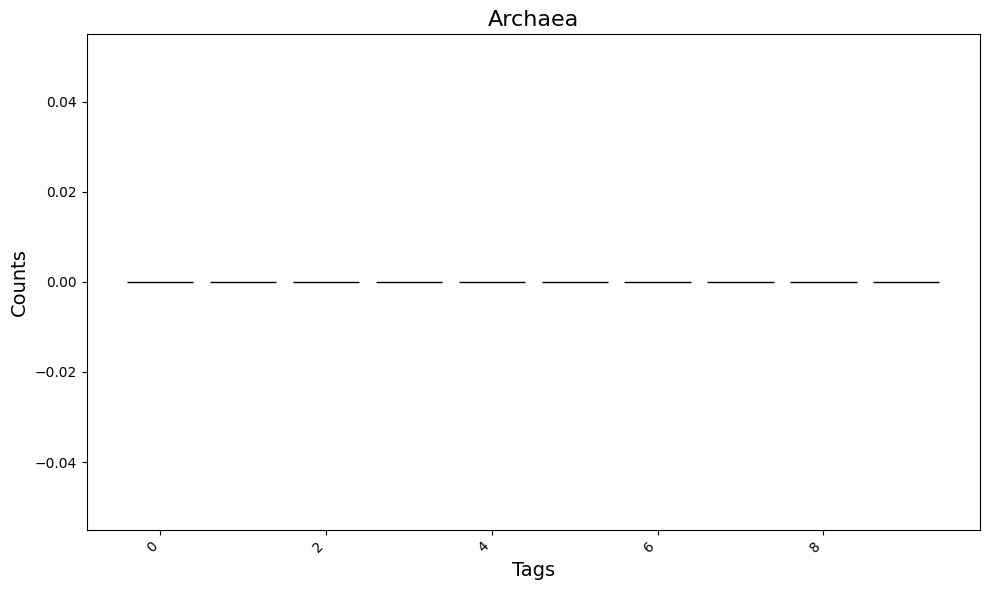

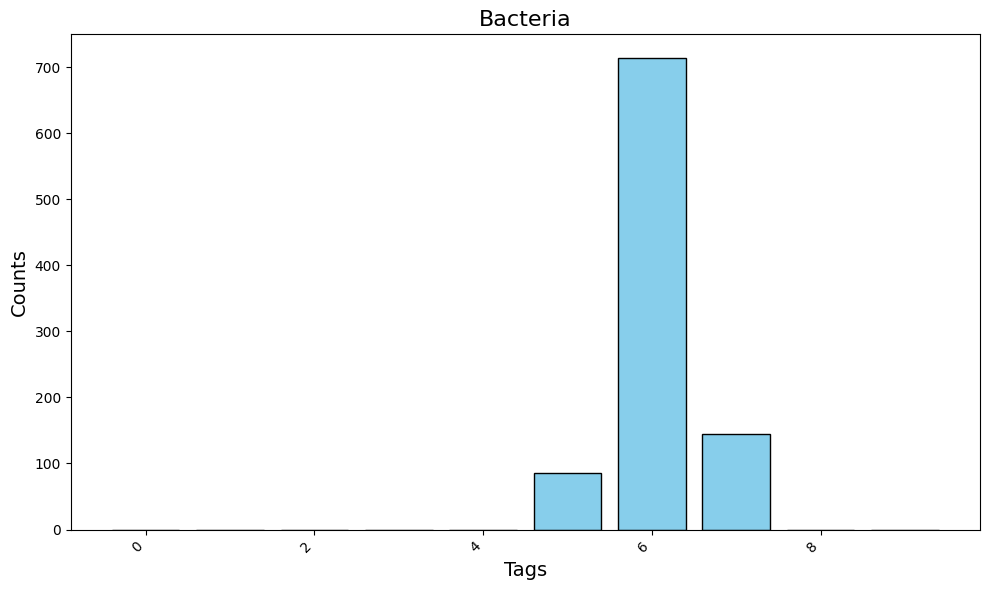

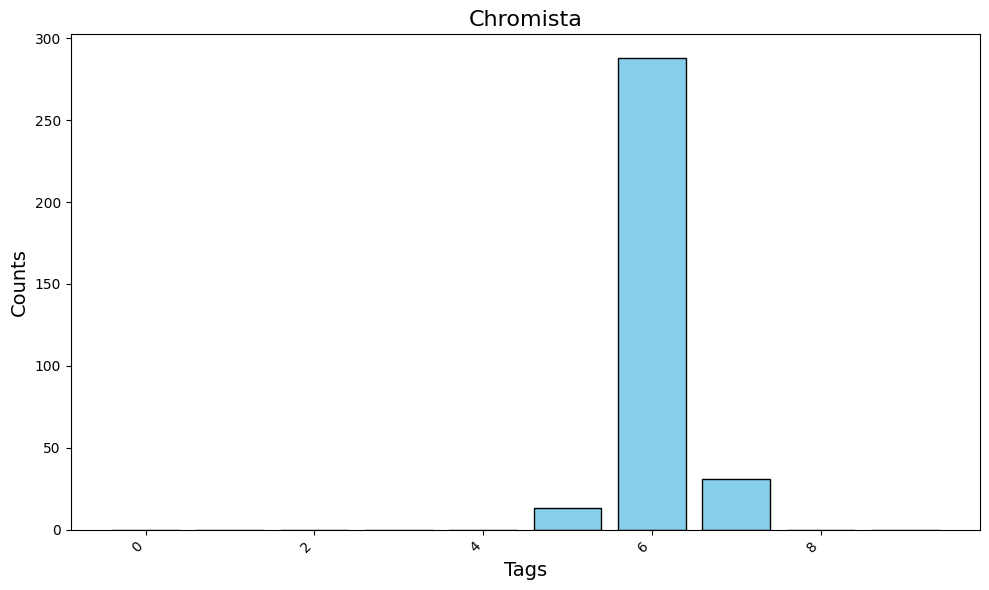

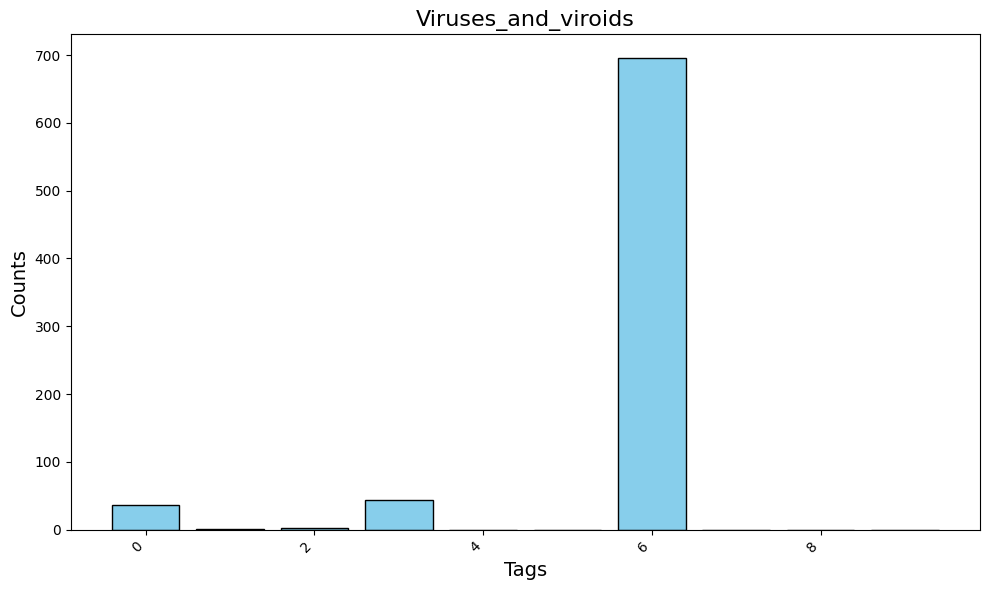

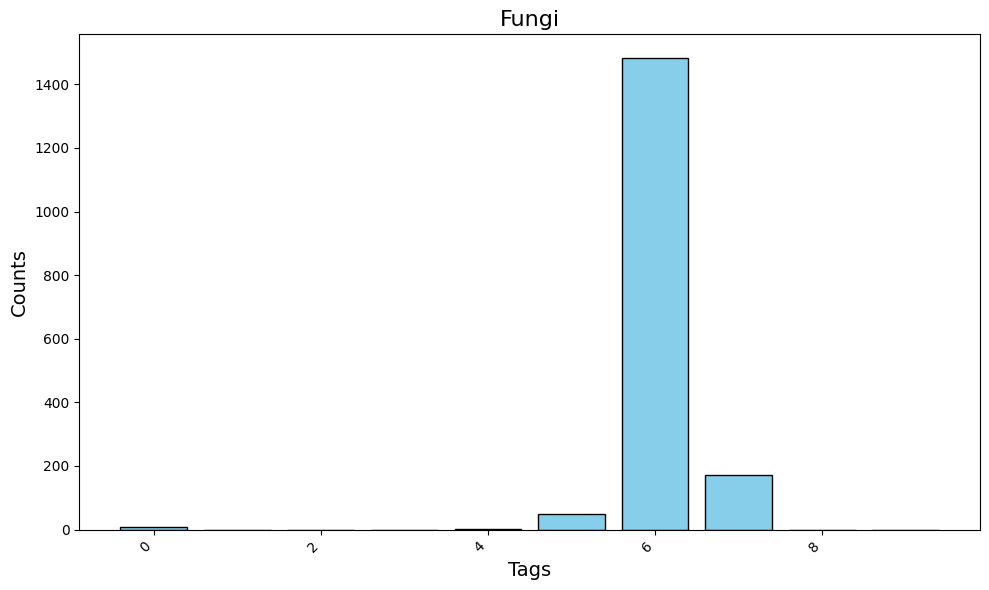

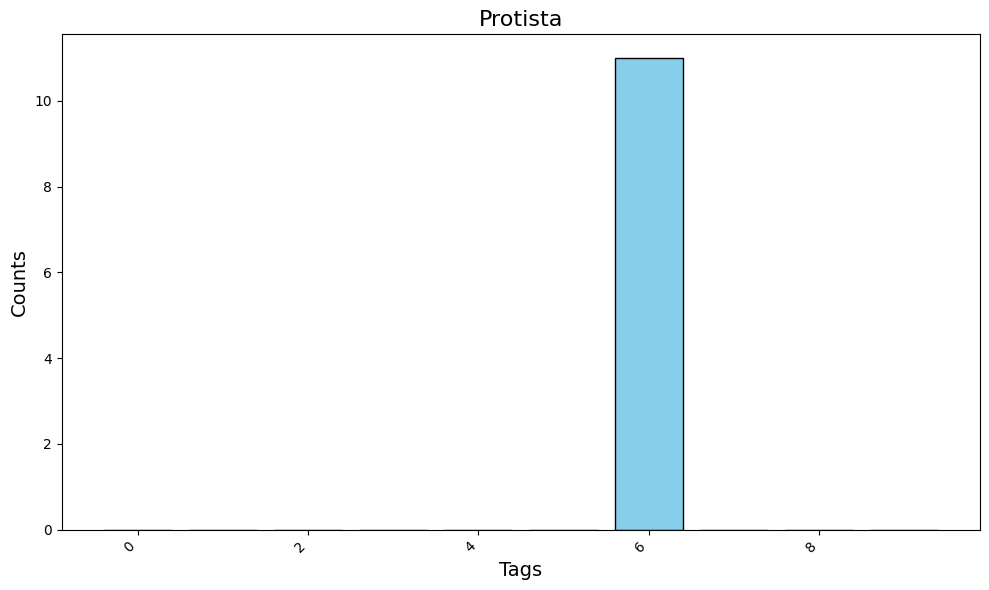

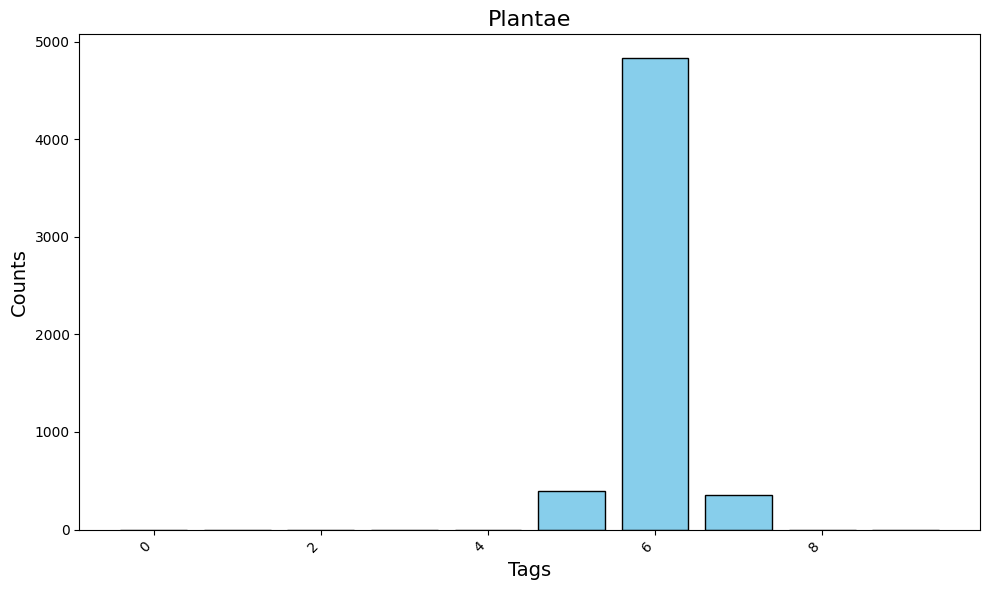

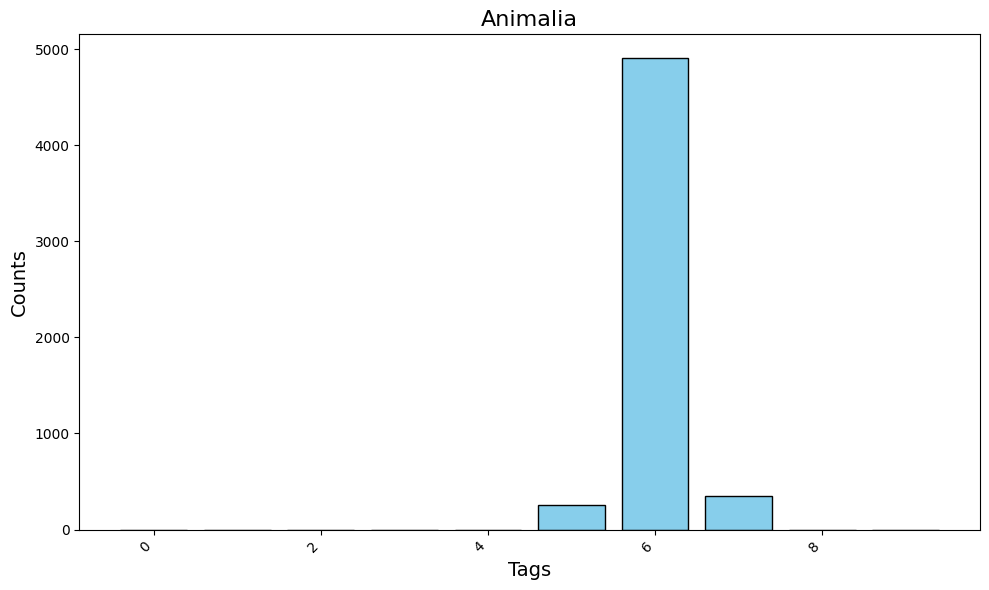

In [463]:
for kingdom in kingdoms:
    plot_tag_histogram(depths[kingdom], f'{kingdom}')

In [428]:
ps = find_node(5984080, taxons['Animalia'])
print(ps.get_attr('higherClassificationMap'))

{"1":"Animalia","54":"Arthropoda","216":"Insecta","809":"Hemiptera","5947":"Ricaniidae","2052176":"Ricania","11344292":"Ricania shantungensis"}


In [421]:
trees['Animalia'][('5984080', 'Pochazia shantungensis')]

Node("/root/('1', 'Animalia')/('54', 'Arthropoda')/('216', 'Insecta')/('809', 'Hemiptera')/('5947', 'Ricaniidae')/('2052176', 'Ricania')/('11344292', 'Ricania shantungensis')/('5984080', 'Pochazia shantungensis')")

In [55]:
question_templates


{'scientific_name': 'What is the scientific name of this {kingdom_word}?',
 'common_name': 'What is the common name in {language} of this {kingdom_word}?',
 'genus_name': 'Which genus does this {kingdom_word} belong to?',
 'major_pest': 'Which of the following is a major pest of this plant?',
 'weed': 'What is the scientific name of the invasive weed in this image?',
 'damage_cause': 'What is the scientific name of the {kingdom_word} causing this damage?',
 'growth_stage': 'At what growth stage is this {kingdom_word}?'}

In [46]:
len(questions)

3259

In [53]:

print(questions[200])

Kingdom: Animalia
Image_path: https://gd.eppo.int/media/data/taxon/A/ANOLCN/pics/1024x0/93.jpg
Question: At what growth stage is this animal?
Options: ['pupa', 'adult', 'egg', 'larva']
Correct_answer: larva
Difficulty: 0
Kingdom_word: animal
Kwargs: {'options': ['pupa', 'adult', 'egg', 'larva'], 'correct_answer': 'larva', 'difficulty': 0, 'image_path': 'https://gd.eppo.int/media/data/taxon/A/ANOLCN/pics/1024x0/93.jpg', 'kingdom': 'Animalia', 'kingdom_word': 'animal'}
Question_template: At what growth stage is this {kingdom_word}?
Tag: growth_stage


In [271]:
async def fetch_image(session, url):
    async with session.get(url) as response:
        if response.status == 200:
            return await response.read()
        else:
            print(f"Failed to fetch image from {url}")
            return None

async def fetch_all_images(urls):
    
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_image(session, url) for url in urls]
        return await asyncio.gather(*tasks)

def process_image(image_data, image_size):
    
    if image_data is None:
        return None
    
    img = Image.open(BytesIO(image_data))
    return img.resize(image_size)

def create_image_grid(images, grid_size=(10, 10), image_size=(100, 100)):
    cols, rows = grid_size
    grid_width = cols * image_size[0]
    grid_height = rows * image_size[1]
    
    grid_image = Image.new("RGB", (grid_width, grid_height), color="white")
    
    for idx, img in enumerate(images):
        if img is None or idx >= cols * rows:
            continue
        
        x = (idx % cols) * image_size[0]
        y = (idx // cols) * image_size[1]
        grid_image.paste(img, (x, y))
    
    grid_image.show()

async def multiprocess(urls, grid_size=(10, 10), image_size=(100, 100)):
    # Step 1: Fetch all images asynchronously
    image_data_list = await fetch_all_images(urls)
    print('All images fetched')
    # Step 2: Use multiprocessing to process images
    with ProcessPoolExecutor(max_workers=32) as executor:
        images = list(executor.map(process_image, image_data_list, [image_size]*len(image_data_list)))
    
    # Step 3: Create and display the image grid
    create_image_grid(images, grid_size=grid_size, image_size=image_size)

async def create_image(urls, number=100):
    cols = int(math.ceil(math.sqrt(number)))
    rows = int(math.ceil(number / cols))
    await multiprocess(urls, grid_size=(cols, rows), image_size=(int(1920/cols), int(1080/rows)))


- In plants, ignore tags: tag-symptoms, eradicate tags: tag-eradication, if tag-invaded-area ask which WEED is this?
- In protista, ignore all tags baby
- In Bacteria, eradicate tag-adult because just two, tag-damage: difficult questions, maybe we can retrieve the attacked species, tag-diagnostic eradictated!!, tag-egg: eRATICATE

· Plantae
- tag-symptoms: ok
- tag-invaded-area: ask weed identification*
- tag-eradication: remove images

· Protista
- all ok

· Bacteria
- tag-adult: remove images,
- tag-damage: identification is a difficult question, ttry to exploit tags,
- tag-diagnostic: remove images,
- tag-eradication: remove images, 
- tag-larva: remove images, 
- tag-symptoms: ok (seems very good)

· Chromista
- no-tag: ok
- tag-damage: Ask damage cause**
- tag-diagnostic: remove images,
- tag-invaded-are: ok
- tag-symptoms: Ask damage cause

· Animalia
- no-tag: ok (a little noisy)
- tag-adult: Ask growth stage***
- tag-damage: Ask damage cause
- tag-diagnostic: remove images
- tag-egg: ok
- eggs: ok
- tag-eradication : remove images
- taginvaded-area: ok
- 'larva': Ask growth stage
- 'pupa': Ask growth stage
- 'symptoms': Ask damage cause

. Fungi
- no-tag: ok
- tag-damage: Ask damage cause
- tag-diagnostic: remove images
- tag-symptoms: Ask damage cause

virsu
- no-tag: damage cause
- tag-adult: remove_images
- tag-damage: damage cause
- tag-diagnostic: remove images
- tag-eggs: ok
- tag-symptoms: damage cause

new_questions = [*weed_identification, **damage_cause, ***growth_stage]





In [301]:
to_remove = {
    'Plantae': ['tag-eradication'],
    'Bacteria': ['tag-adult', 'tag-diagnostic', 'tag-eradication', 'tag-larva'],
    'Chromista': ['tag-diagnostic'],
    'Animalia': ['tag-diagnostic', 'tag-eradication'],
    'Fungi': ['tag-diagnostic'],
    'Viruses_and_viroids': ['tag-adult', 'tag-diagnostic']
}

weed_identification =  {
    'Plantae': ['tag-invasive-area']
}

damage_cause =  {
    'Bacteria': ['tag-damage'],
    'Chromista': ['tag-damage','tag-symptoms'],
    'Animalia': ['tag-damage', 'tag-symptoms'],
    'Fungi': ['tag-damage', 'tag-symptoms'],
    'Viruses_and_viroids': ['','tag-damage', 'tag-symptoms']   
}

growth_stage =  {
    'Animalia': ['tag-adult', 'tag-larva', 'tag-pupa'], 
}

# Tags

In [283]:
tags[kingdom]

{'adult', 'damage', 'diagnostic', 'eggs', 'symptoms'}

['tag-eggs']
All images fetched


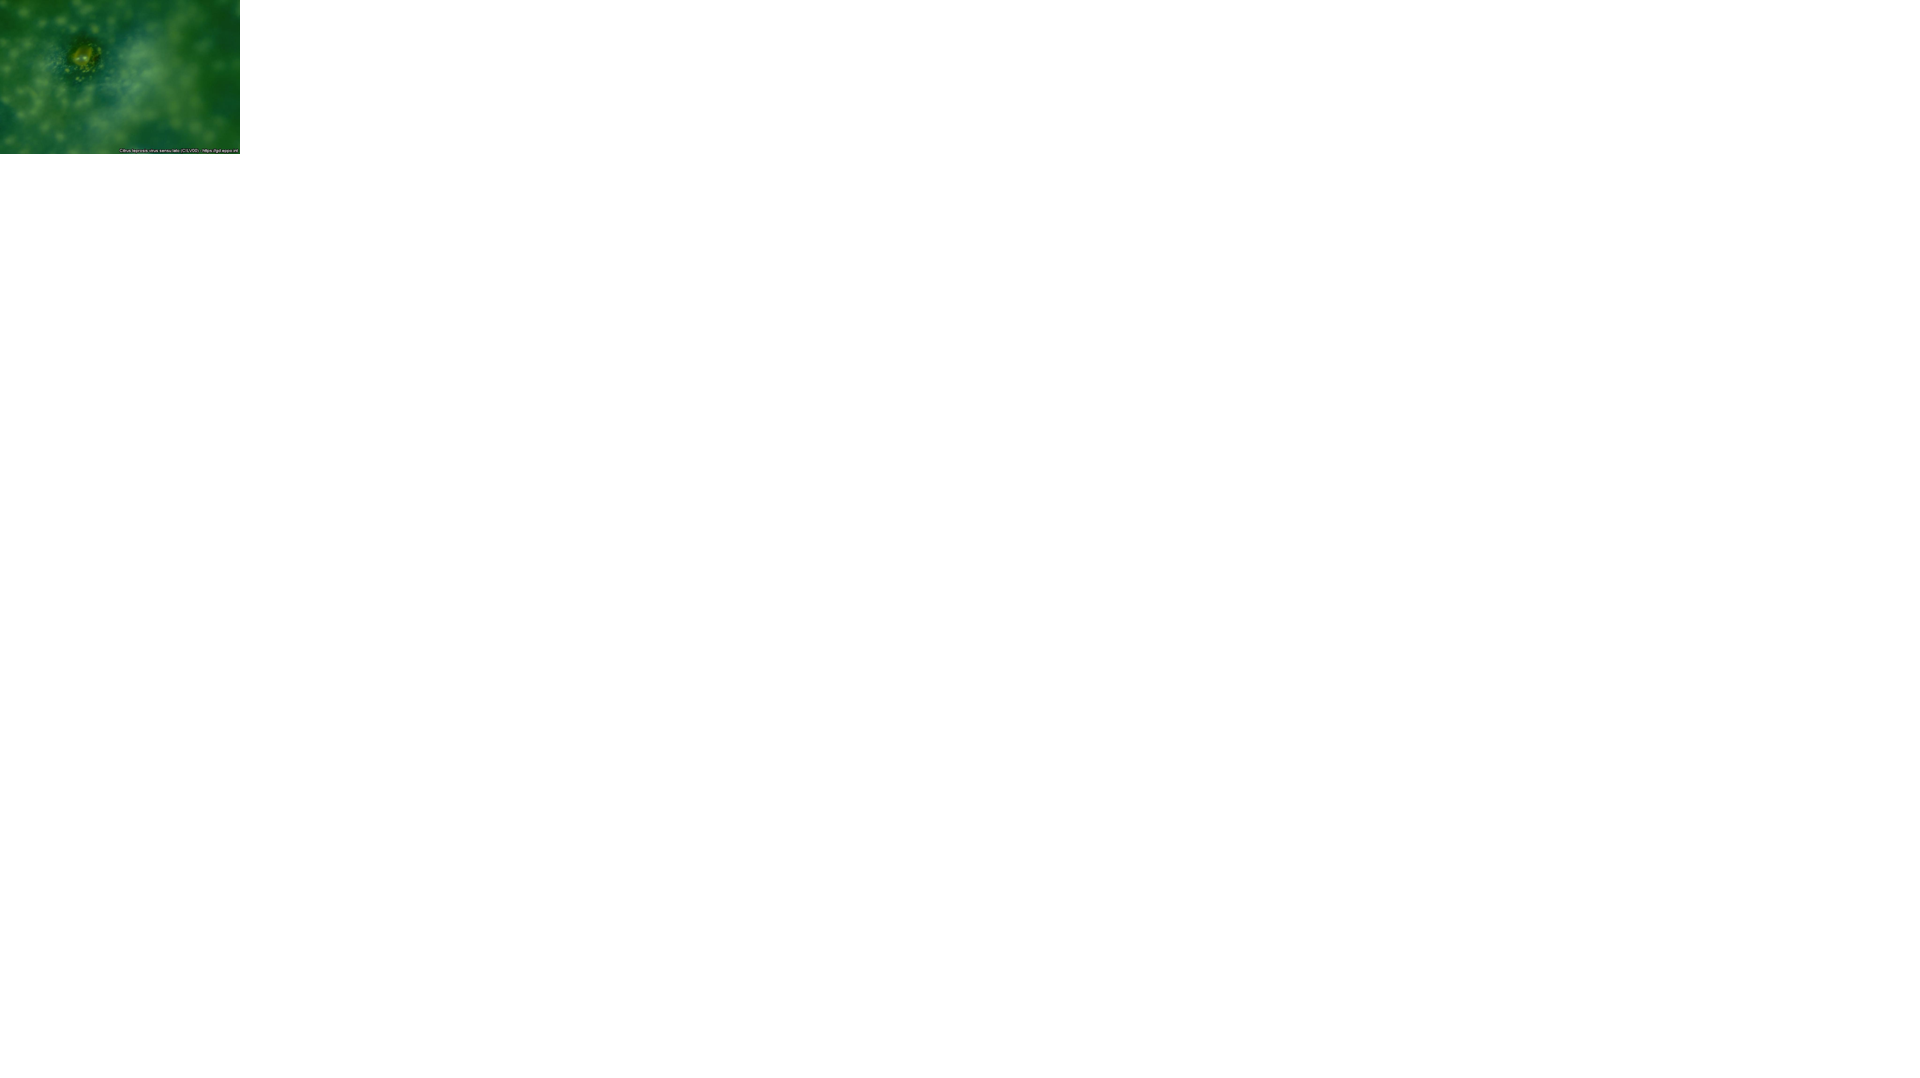

In [294]:
kingdom = 'Viruses_and_viroids'
tag = 'tag-eggs'
urls = []
captions = []
for image in EPPO_images[kingdom]:
    if tag in image.tag:
    #if len(image.tag)<1:
        print(image.tag)
        urls.append(image.image_path)
        captions.append((image.taxon,image.caption))
len(urls)
await create_image(urls,number=50)